<a href="https://colab.research.google.com/github/Isi2000/GAN/blob/main/VGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VANILLA GAN

This notebook aims at creating an implementation of the vanilla **Vanilla GAN**
described in the first 2 chapters of YANG WANG's paper (note that it was first Goodfellow's idea)

In [7]:
import torch
from torch.utils.data import Dataset
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torch.nn as nn


In [15]:

import torch.nn.functional as F

import torchvision
import torchvision.transforms as T

from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image

# keras-style network summary
from torchsummary import summary

In [8]:


training_data = MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])
torch.Size([1, 28, 28])


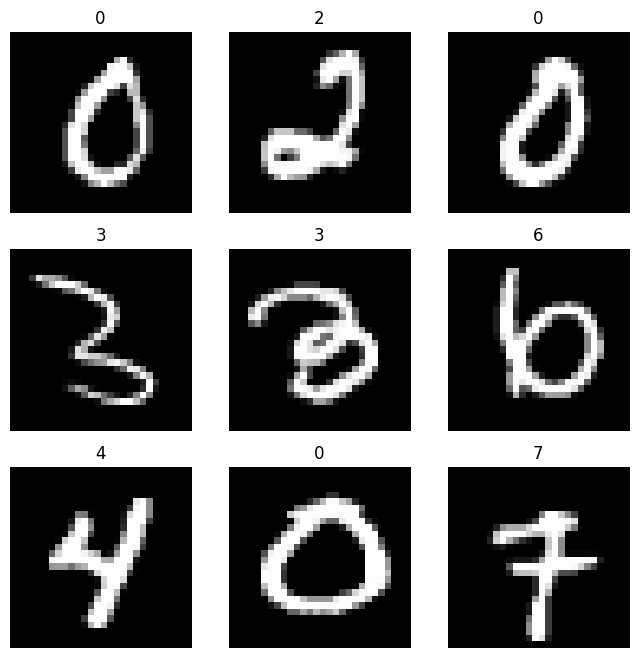

In [13]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    print(img.size())
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [10]:
if torch.cuda.is_available():
    print("Congratulations, you have a GPU!")
else:
    print("PyTorch cannot see your GPU :(")
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


Congratulations, you have a GPU!


In [46]:
class Discriminator(nn.Module):
    def __init__(self, filters: list, units: list, activation=F.leaky_relu, kernel=3):
        super().__init__()

        filters = [1] + filters
        units = [filters[-1] * (len(filters)-1)//2 *  (len(filters)-1)//2]+ units + [10]

        # NOTE: never ever add layers into python's list...
        self.convs = nn.ModuleList()
        self.fc = nn.ModuleList()
        self.activation = activation

        # define convolutions
        for i, num_filters in enumerate(filters[1:]):
            conv = nn.Conv2d(in_channels=filters[i], out_channels=num_filters,
                             kernel_size=kernel, padding='same')

            self.convs.append(conv)

        self.max_pool = nn.MaxPool2d(2, 2)

        # define dense layers
        for i, num_units in enumerate(units[1:]):
            fc = nn.Linear(units[i], num_units)
            self.fc.append(fc)


    def forward(self, x):
        for i, layer in enumerate(self.convs):
            x = self.activation(layer(x))

            if i % 2 == 1:
                # downsample by 2 on 2nd conv layer
                x = self.max_pool(x)

        x = torch.flatten(x, start_dim=1)

        for layer in self.fc:
            x = self.activation(layer(x))

        return F.log_softmax(x)

netG= Discriminator(filters=[4,4,8,8, 16, 16], units=[64], kernel=3).to(device)
summary(netG, (1,28,28), device ='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
            Conv2d-2            [-1, 4, 28, 28]             148
         MaxPool2d-3            [-1, 4, 14, 14]               0
            Conv2d-4            [-1, 8, 14, 14]             296
            Conv2d-5            [-1, 8, 14, 14]             584
         MaxPool2d-6              [-1, 8, 7, 7]               0
            Conv2d-7             [-1, 16, 7, 7]           1,168
            Conv2d-8             [-1, 16, 7, 7]           2,320
         MaxPool2d-9             [-1, 16, 3, 3]               0
           Linear-10                   [-1, 64]           9,280
           Linear-11                   [-1, 10]             650
Total params: 14,486
Trainable params: 14,486
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/ba

<ipython-input-46-a4137d5d7fa4>:41: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
